# This is DEV test notebook, not much useful around here

In [6]:
# module reloading script, fetches updates to ml4fmri package
import sys, importlib
from pathlib import Path

PKG = "ml4fmri"
# adjust as needed; this assumes your repo root is the CWD and sources are in ../src
SRC = Path().joinpath("../src").resolve()

def _ensure_src_on_path():
    p = str(SRC)
    if p not in sys.path:
        sys.path.insert(0, p)

def fresh_import_ml4fmri():
    """
    Remove any cached ml4fmri modules and import from SRC.
    Returns the ml4fmri module and (if available) meanMLP class.
    """
    _ensure_src_on_path()

    # purge previous imports so code changes take effect
    to_delete = [k for k in list(sys.modules) if k == PKG or k.startswith(PKG + ".")]
    for k in to_delete:
        del sys.modules[k]

    importlib.invalidate_caches()

    ml4fmri = __import__(PKG)
    meanMLP = None
    try:
        from ml4fmri.models import meanMLP 
    except Exception as e:
        print("Note: could not import meanMLP yet:", e)

    try:
        import inspect
        print("ml4fmri imported from:", Path(inspect.getfile(ml4fmri)).parent)
    except Exception:
        pass
    print("ml4fmri ready")
    return ml4fmri

# --- first import (or manual reload later) ---
ml4fmri = fresh_import_ml4fmri()

# get sample data for experiments
from abide import load_data as load_abide
from cobre import load_data as load_cobre

data, labels = load_abide()
data.shape, labels.shape

data, labels = data[:100], labels[:100]

ml4fmri imported from: /Users/ppopov1/meanMLP/src/ml4fmri
ml4fmri ready


In [17]:
from abide import load_data as load_abide
from cobre import load_data as load_cobre

data, labels = load_abide()
DATA, LABELS = data, labels
data.shape, labels.shape

data, labels = data[50:150], labels[50:150]

In [ ]:
ml4fmri = fresh_import_ml4fmri()
from ml4fmri import cvbench # runs CV experiments with implemented models on the given data
report = cvbench(data, labels, n_folds=10)
# report = cvbench(data, labels, models='lite', n_folds=2)
# report = cvbench(data, labels, models='LR', n_folds=2)
report.plot_scores()

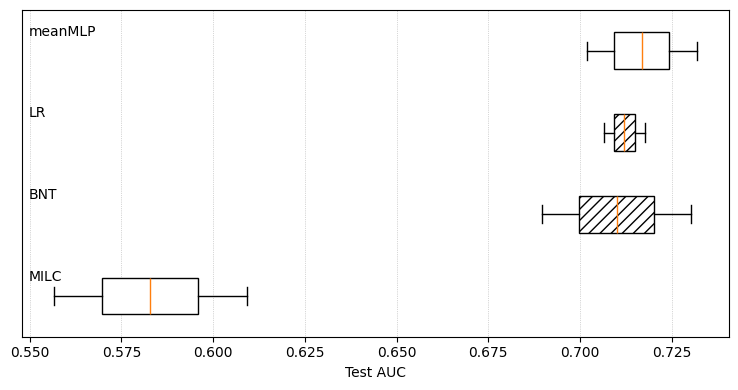

In [4]:
report.plot_scores_h()

# test cvbench model socket

In [3]:

import torch
from torch import nn

from torch.nn.functional import cross_entropy, mse_loss

from ml4fmri.models.helper_functions import basic_ce_loss, basic_handle_batch, basic_dataloader, basic_Adam_optimizer, BasicTrainer

class LSTM(nn.Module):
    """
    TIME SERIES MODEL

    Vanilla-style LSTM classifier for fMRI data from https://doi.org/10.1016/j.neuroimage.2024.120909.
    Expected input shape: [batch_size, time_length, input_feature_size].
    Output: [batch_size, n_classes]
    """

    def __init__(
            self,
            input_size: int,
            output_size: int,
            hidden_size: int = 210,
            num_layers: int = 1,
            bidirectional: bool = False,
            dropout: float = 0.5,
            lr: float = 4e-5,
    ):
        """
        Initialize LSTM model.
        Args:
            input_size (int): Size of the vector at each time step in the input time series. \
                Common to all models, for FNC models it is the number of nodes (width or length) in the FNC matrix.
            output_size (int): Number of classes for classification. \
                Common to all models.
            hidden_size (int, hyperparameter): LSTM hidden size. Defaults to 210.
            num_layers (int, hyperparameter): Number of LSTM layers. Defaults to 1.
            bidirectional (bool, hyperparameter): Whether to use a bidirectional LSTM. Defaults to True.
            dropout (float, hyperparameter): Dropout rate for classifier. Defaults to 0.5.
            lr (float, hyperparameter): Learning rate for the optimizer. Defaults to 4e-5. \
                Common to all models. Isn't used by the model per se, presented as a reference LR from the paper. 
        """
        super().__init__()
        self.lr = lr  # learning rate used in the paper. Defined like this in every model for reference.

        self.bidirectional = bidirectional
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
        )

        lstm_output_size = 2 * hidden_size if bidirectional else hidden_size

        self.predictor = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(
                lstm_output_size,
                lstm_output_size,
            ),
            nn.ReLU(),
            nn.Linear(
                lstm_output_size,
                input_size,
            ),
        )

        self.clf = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(
                lstm_output_size,
                output_size,
            ),
        )

    def forward(self, x):
        lstm_output, _ = self.lstm(x)

        if self.bidirectional:
            out_forward = lstm_output[:, -1, : self.hidden_size]
            out_reverse = lstm_output[:, 0, self.hidden_size :]
            lstm_output_clf = torch.cat((out_forward, out_reverse), 1)
        else:
            lstm_output_clf = lstm_output[:, -1, :]

        preds = self.predictor(lstm_output[:, :-1, :])
        origs = x[:, 1:, :]

        ts_logits = self.clf(lstm_output)
        logits = ts_logits.mean(axis=1)

        return logits, {"logits": logits, "preds": preds, "origs": origs, "ts_logits": ts_logits}

    #### Helper functions for model training and evaluation ####

    def compute_loss(self, loss_load, targets):
        """
        Standard loss computation routine for models.
        Args:
            loss_load (dict): Forward's second output for the batch.
            targets (torch.Tensor): True labels for the batch.
        
        Returns
        -------
        loss : Tensor
            Loss for backpropagation.
        logs : dict
            Dictionary containing the loss components for logs.
        """

        ce_loss = cross_entropy(loss_load["logits"], targets)
        pred_loss = mse_loss(loss_load["preds"], loss_load["origs"])

        loss = ce_loss + pred_loss

        return loss, {"CE_loss": float(ce_loss.detach().cpu().item()), "Pred_loss": float(pred_loss.detach().cpu().item())}

    def handle_batch(self, batch):
        """
        Standard batch handling routine for models. 
        Returns loss for backprop and a dictionary of classification metrics and losses for logs.
        
        Args:
            batch (tuple): A batch containing the time series data and labels as a tuple.
        Returns
        -------
        loss : Tensor
            Loss for backpropagation.
        batch_log : dict
            Dictionary of classification metrics and losses for logs.
        """

        loss, batch_log = basic_handle_batch(self, batch)
        return loss, batch_log
    
    def get_optimizer(self, lr=None):
        """
        Standard optimizer getter routine for models.
        """
        if lr is None:
            lr = self.lr
        return basic_Adam_optimizer(self, lr)

    @staticmethod
    def prepare_dataloader(data,
                           labels,
                           batch_size: int = 64,
                           shuffle: bool = True):
        """
        Returns torch DataLoader that produces appropriate batches for the model (can pass to `handle_batch`)
        Args:
            data (array-like): Time series data of shape (B, T, D).
            labels (array-like): Class labels for the data.
            batch_size (int, optional): Batch size for the DataLoader. Defaults to 64.
            shuffle (bool, optional): Whether to shuffle batching in the DataLoader. Defaults to True.
        
        Returns:
            DataLoader: A PyTorch DataLoader generating the batches of time series data and labels. 
        """
        return basic_dataloader(data,
                                labels,
                                type="TS",
                                batch_size=batch_size,
                                shuffle=shuffle)
    
    def train_model(self,
              train_loader,
              val_loader,
              test_loader,
              epochs: int = 200,
              lr: float = None,
              device: str = None,
              patience: int = 30,
        ):
        """
        Standard model training routine.
        Args:
            train_loader (DataLoader): DataLoader for the training set. Used for training.
            val_loader (DataLoader): DataLoader for the validation set. Used during training to find most generalizable model.
            test_loader (DataLoader): DataLoader for the test set.
            epochs (int, optional): Number of training epochs. Defaults to 200.
            lr (float, optional): Optimizer learning rate (default: use model's self.lr).
            device (str, optional): Device to train the model on: "cuda", "mps", or "cpu". Default: auto-detect (cuda -> mps -> cpu).
            patience (int, optional): Early stopping patience (in epochs). Defaults to 30.
        Returns
        -------
        (train_logs, test_logs)
            Training and test dataframes containing loss and accuracy metrics.
        """
        
        trainer = BasicTrainer(
            model=self,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            epochs=epochs,
            lr=lr,
            device=device,
            patience=patience,
        )

        train_logs, test_logs = trainer.run()
        return train_logs, test_logs


In [ ]:
ml4fmri = fresh_import_ml4fmri()
from ml4fmri import cvbench # runs CV experiments with implemented models on the given data
# report = cvbench(data, labels, n_folds=10)
report = cvbench(data, labels, models=["meanMLP", "LSTM"], custom_models=[LSTM], n_folds=5)
# report = cvbench(data, labels, models=["meanMLP", "LSTM"], n_folds=5)
report.plot_scores()

# test cvbench

In [7]:
ml4fmri = fresh_import_ml4fmri()
from ml4fmri import cvbench # runs CV experiments with implemented models on the given data
# report = cvbench(data, labels, n_folds=10)
report = cvbench(data, labels, device=all, n_folds=2)
report.plot_scores()

cvbench INFO: Got DATA in shape (569, 140, 53) and LABELS in shape (569,)
cvbench INFO: Unique labels: [0 1], Counts: [255 314]
cvbench INFO: Using device: <built-in function all>
cvbench INFO: Running models: ['LR', 'meanMLP', 'MILC', 'Transformer', 'meanTransformer', 'BNT', 'BrainNetCNN', 'LSTM', 'meanLSTM', 'FBNetGen', 'DICE', 'Glacier', 'BolT']
cvbench INFO: Training model: LR
cvbench.LR INFO: Fold 01/02: Train/Val/Test AUC 1.000/1.000/0.707: Time elapsed 0.13 s


ml4fmri imported from: /Users/ppopov1/meanMLP/src/ml4fmri
ml4fmri ready


cvbench.LR INFO: Fold 02/02: Train/Val/Test AUC 1.000/1.000/0.718: Time elapsed 0.11 s
cvbench INFO: Training model: meanMLP


TypeError: device() received an invalid combination of arguments - got (builtin_function_or_method), but expected one of:
 * (torch.device device)
      didn't match because some of the arguments have invalid types: (!builtin_function_or_method!)
 * (str type, int index = -1)


In [ ]:
# ml4fmri = fresh_import_ml4fmri()
from ml4fmri import cvbench # runs CV experiments with implemented models on the given data
# report = cvbench(data, labels, n_folds=10)
report = cvbench(data, labels, device="mps", n_folds=10)
report.plot_scores()

In [ ]:
report.plot_scores_h(metric='test_f1_macro')

In [ ]:
# extract report dataframes

test_df = report.get_test_dataframe() # returns dataframe with test metrics: 
# classification metrics and loss on the test data and training time per fold for each model.
# Useful for model comparison.

train_df = report.get_train_dataframe() # returns dataframe with training logs: 
# losses and classification metrics on the training and validation data per fold for each model. 
# Useful for training inspection.

meta_df = report.get_meta() # dictionary with metadata about the training process:
# ['models', 'n_folds', 'val_ratio', 'random_state', 'input_size', 'n_classes', 'train_indices', 'val_indices', 'test_indices']
# the last 3 give you CV indices per fold, so that you can potentially replicate the splits in your experiments.

In [ ]:
report.plot_training_curves()

In [ ]:
train_df = report.get_train_dataframe()
test_df = report.get_test_dataframe()
meta = report.meta

In [ ]:
report.save() # saves the report to disk: 
# cvbench_train.csv with train dataframe, 
# cvbench_test.csv with test dataframe,
# cvbench_meta.json with metadata,